# Main Quest 01 : 폐렴 진단기 성능개선

### Rubric
1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.
    - 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.


2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.
    - regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.


3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.
    - Accuracy 기준 85%에 도달하였다.


### 목차
- Step1. 실험환경 Set-up
- Step2. 데이터 준비하기
- Step3. 데이터 시각화
- Step4. RestNet-18 구현 모델링
- Step5. 데이터 imbalance 처리
- Step6. 모델 훈련
       - Case 1.
       - Case 2.
       - Case 3.
       - Case 4.
       - 각 Case 에 대한 결과 확인과 시각화


- 결과 정리

### 첨언
- 본래 위와 같은 목차 방식으로 한번 돌렸었는데, 내역이 날라가서 미완성이 상태로 제출합니다. 
- 정확한 수치가 기억나지는 않으나, epoch 25 기준 Case 3. Augmentation : Random Resize + Crop 가 성능이 가장 높았음 (대략 91 % 로 기억..) 
- 평가 받은 후, 다시 한번 다 돌려서 output 도 포함된 내역을 업데이트 하도록 하겠습니다.

---

# Step 1. 실험환경 Set-up

In [1]:
import re                                               # 정규표현식 관련 패키지
import os                                               # I/O 관련 패키지
import pandas as pd                                     # 데이터 전처리 관련 패키지
import numpy as np                                      # 데이터 array 관련 패키지
import tensorflow as tf                                 # 딥러닝 패키지
import matplotlib.pyplot as plt                         # 데이터 시각화패키지
from sklearn.model_selection import train_test_split
import random, math

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 8
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


# Step 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print('훈련 데이터 갯수: {}'.format(len(train_filenames)))
print('테스트 데이터 갯수: {}'.format(len(test_filenames)))
print('검증 데이터 갯수: {}'.format(len(val_filenames)))

훈련 데이터 갯수: 5216
테스트 데이터 갯수: 624
검증 데이터 갯수: 16


- train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다.  
- 개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.  
- train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.  

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('훈련 데이터 갯수: {}'.format(len(train_filenames)))
print('검증 데이터 갯수: {}'.format(len(val_filenames)))

훈련 데이터 갯수: 4185
검증 데이터 갯수: 1047


In [5]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


- 결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다. 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.

- tf.data 인스턴스를 만들어 봅시다. tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해줍니다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


- 현재 이미지에는 라벨 데이터가 따로 없습니다.
- 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
# 테스트 데이터도 동일한 작업을 해줍니다.
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print('테스트 데이터 갯수: {}'.format(TEST_IMAGE_COUNT))

테스트 데이터 갯수: 624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Step 3. 데이터 시각화

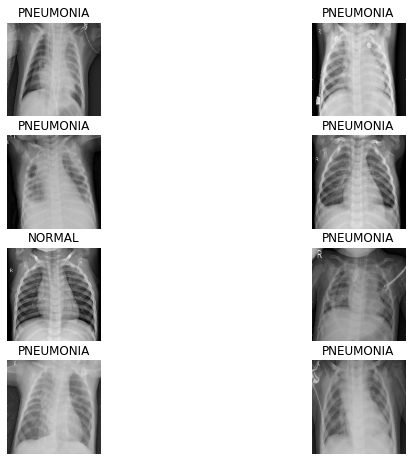

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. Resnet18 구현

In [16]:


import tensorflow as tf
from tensorflow.keras import layers, Model

class ConvBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size, strides, padding='same'):
        super(ConvBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)
        self.batch_norm = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.batch_norm(x)
        x = self.relu(x)
        return x



In [17]:
class IdentityBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(IdentityBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, 1, padding='same')  
        self.conv_block1 = ConvBlock(filters, kernel_size, strides=1)
        self.conv2 = layers.Conv2D(filters, kernel_size, padding='same')
        self.batch_norm = layers.BatchNormalization()

    def call(self, inputs):
        residual = self.conv1(inputs)  
        x = self.conv_block1(inputs)
        x = self.conv2(x)
        x = self.batch_norm(x)
        x = layers.add([x, residual])
        x = layers.ReLU()(x)
        return x

In [18]:
class ResNet18(tf.keras.Model):
    def __init__(self, input_shape, num_classes=1):
        super(ResNet18, self).__init__()
        self.input_tensor = layers.Input(shape=input_shape)
        self.conv_block = ConvBlock(filters=64, kernel_size=7, strides=2)
        self.max_pool = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')

        self.filters_list = [64, 128, 256, 512]
        self.IdentityBlocks = [
            IdentityBlock(filters=filters, kernel_size=3) for filters in self.filters_list
        ] + [
            IdentityBlock(filters=filters * 2, kernel_size=3) for filters in self.filters_list
        ]  

        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.dense = layers.Dense(num_classes, activation='sigmoid')

    def call(self, inputs):
        x = self.conv_block(inputs)
        x = self.max_pool(x)

        for block in self.IdentityBlocks:
            x = block(x)

        x = self.global_avg_pool(x)
        x = self.dense(x)

        return x

# Step 5. 데이터 imbalance 처리

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


- 이 예의 앞부분에서 정상보다 폐렴으로 분류된 이미지가 더 많아 데이터가 불균형한 것을 보았습니다.
- 클래스 0(정상)의 가중치는 클래스 1(폐렴)의 가중치보다 훨씬 높습니다 .
- 정규 이미지가 적기 때문이며, CNN은 훈련 데이터가 균형을 이룰 때 가장 잘 작동하므로, 각 정상 이미지는 데이터 균형을 위해 더 많은 가중치를 부여합니다.

# Step 6. 모델 훈련 :

## Case 1: 적용 안함

In [20]:


with tf.device('/GPU:0'):
    input_shape = (180, 180, 3)
    model = ResNet18(input_shape) # Resnet18
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )



In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
523/523 [==============================] - 253s 446ms/step - loss: 0.3903 - accuracy: 0.8478 - precision: 0.9412 - recall: 0.8484 - val_loss: 0.7590 - val_accuracy: 0.7413 - val_precision: 0.7391 - val_recall: 1.0000
Epoch 2/10
523/523 [==============================] - 232s 443ms/step - loss: 0.3254 - accuracy: 0.8714 - precision: 0.9532 - recall: 0.8700 - val_loss: 1.0047 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/10
523/523 [==============================] - 231s 443ms/step - loss: 0.3123 - accuracy: 0.8853 - precision: 0.9573 - recall: 0.8854 - val_loss: 0.3303 - val_accuracy: 0.8221 - val_precision: 0.8063 - val_recall: 0.9974
Epoch 4/10
523/523 [==============================] - 232s 443ms/step - loss: 0.2758 - accuracy: 0.8941 - precision: 0.9597 - recall: 0.8953 - val_loss: 7.3523 - val_accuracy: 0.2673 - val_precision: 1.0000 - val_recall: 0.0039
Epoch 5/10
523/523 [==============================] - 231s 443ms/step - loss: 0.2202 - a

In [22]:
model.summary()

Model: "res_net18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_block (ConvBlock)       multiple                  9728      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
identity_block (IdentityBloc multiple                  78528     
_________________________________________________________________
identity_block_1 (IdentityBl multiple                  230784    
_________________________________________________________________
identity_block_2 (IdentityBl multiple                  920320    
_________________________________________________________________
identity_block_3 (IdentityBl multiple                  3675648   
_________________________________________________________________
identity_block_4 (IdentityBl multiple                  80


### 결과 확인과 시각화

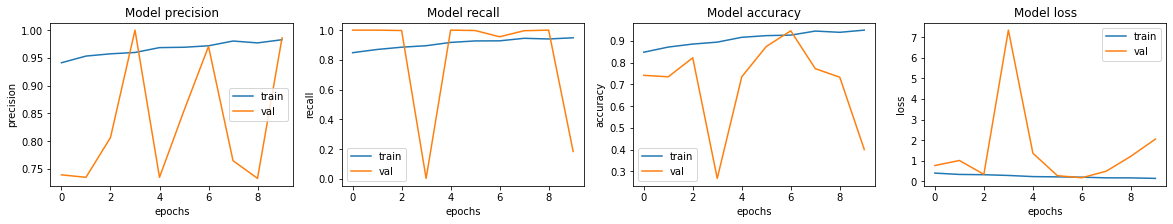

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 [==============================] - 12s 146ms/step - loss: 1.4946 - accuracy: 0.4840 - precision: 0.8469 - recall: 0.2128
Loss: 1.4946205615997314,
Accuracy: 0.4839743673801422,
Precision: 0.8469387888908386,
Recall: 0.21282051503658295


## Case2 : Augmentation : Random Brightness + Saturation 

In [25]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [26]:
def augment(image,label):

     # Random Brightness + Saturation
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.clip_by_value(image, 0.0, 1.0) # keeping pixel values in check

    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가됨
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds


train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

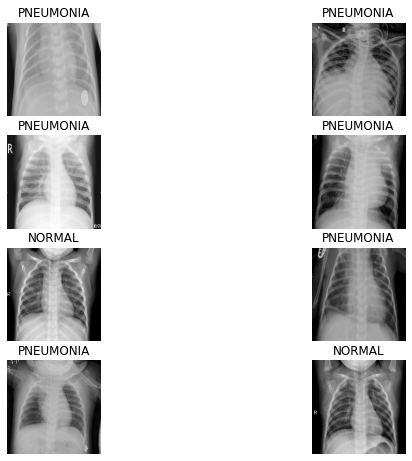

In [27]:
image_batch, label_batch = next(iter(train_ds))

show_batch(image_batch.numpy(), label_batch.numpy())

In [28]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [37]:
with tf.device('/GPU:0'):
    input_shape = (180, 180, 3)
    model = ResNet18(input_shape) # Resnet18
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )



In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=20,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
523/523 [==============================] - 243s 449ms/step - loss: 0.3890 - accuracy: 0.8470 - precision: 0.9356 - recall: 0.8532 - val_loss: 2.0231 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/20
523/523 [==============================] - 234s 447ms/step - loss: 0.3265 - accuracy: 0.8671 - precision: 0.9488 - recall: 0.8684 - val_loss: 0.8219 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/20
523/523 [==============================] - 234s 447ms/step - loss: 0.3201 - accuracy: 0.8678 - precision: 0.9558 - recall: 0.8621 - val_loss: 0.7549 - val_accuracy: 0.7433 - val_precision: 0.7408 - val_recall: 1.0000
Epoch 4/20
523/523 [==============================] - 233s 445ms/step - loss: 0.2963 - accuracy: 0.8846 - precision: 0.9573 - recall: 0.8844 - val_loss: 0.5849 - val_accuracy: 0.7010 - val_precision: 0.7637 - val_recall: 0.8570
Epoch 5/20
523/523 [==============================] - 233s 446ms/step - loss: 0.2617 - a

###  결과 확인 및 시각화

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

## Case 3.  Augmentation : Random Resize + Crop 

In [30]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [31]:
def augment(image,label):

    # random resize and random crop back to expected size
    random_scale_factor = tf.random.uniform([1], minval=1., maxval=1.4, dtype=tf.float32)
    scaled_height = tf.cast(tf.cast(input_shape[0], tf.float32) * random_scale_factor, tf.int32)
    scaled_width = tf.cast(tf.cast(input_shape[1], tf.float32) * random_scale_factor, tf.int32)
    scaled_shape = tf.squeeze(tf.stack([scaled_height, scaled_width]))

    image = tf.image.resize(image, scaled_shape)
    image = tf.image.random_crop(image, input_shape)

    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가됨
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds


train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

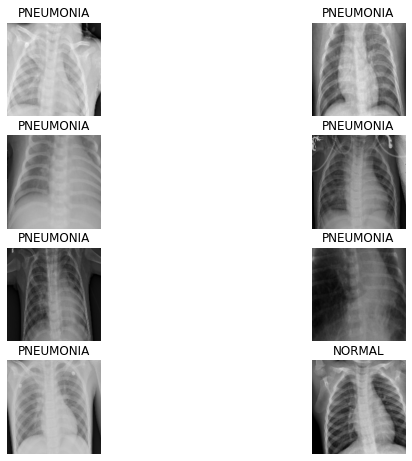

In [32]:
image_batch, label_batch = next(iter(train_ds))

show_batch(image_batch.numpy(), label_batch.numpy())

In [33]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [34]:
with tf.device('/GPU:0'):
    model = Resnet()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

NameError: name 'build_model' is not defined

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

### 결과 확인 및 시각화

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

## Case 4. : Augmentation : Random Brightness + Saturation + Resize + Crop

In [ ]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
def augment(image,label):

    # Random B+S changes
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.clip_by_value(image, 0.0, 1.0) # keeping pixel values in check

    # random resize and random crop back to expected size
    random_scale_factor = tf.random.uniform([1], minval=1., maxval=1.4, dtype=tf.float32)
    scaled_height = tf.cast(tf.cast(input_shape[0], tf.float32) * random_scale_factor, tf.int32)
    scaled_width = tf.cast(tf.cast(input_shape[1], tf.float32) * random_scale_factor, tf.int32)
    scaled_shape = tf.squeeze(tf.stack([scaled_height, scaled_width]))

    image = tf.image.resize(image, scaled_shape)
    image = tf.image.random_crop(image, input_shape)

    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가됨
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds


train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [ ]:
image_batch, label_batch = next(iter(train_ds))

show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

In [ ]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

## 결과 정리
[Case1]

[Case2]


[Case3]

[Case4]



### 가능 성능이 좋았던 Case :

Case 3. Augmentation : Random Resize + Crop 

